In [34]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Dropout, MaxPooling1D, LSTM, Conv1D

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report

import torch

In [2]:
import kagglehub

path = kagglehub.dataset_download("deepcontractor/musical-instrument-chord-classification")

print("Path to dataset files:", path)

100%|██████████| 135M/135M [00:00<00:00, 157MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/deepcontractor/musical-instrument-chord-classification/versions/2


In [3]:
# Путь к директории
DATA_DIR = "/root/.cache/kagglehub/datasets/deepcontractor/musical-instrument-chord-classification/versions/2/Audio_Files"
LABELS = ["Major", "Minor"]

def load_audio_files(data_dir, labels, sr=16000, duration=5):
    X, y = [], []
    for label in labels:
        folder = os.path.join(data_dir, label)
        for fname in os.listdir(folder):
            path = os.path.join(folder, fname)
            audio, _ = librosa.load(path, sr=sr, mono=True) #загрузка аудио
            audio = librosa.util.fix_length(audio, size=sr*duration)# Приведение к фиксированной длине
            X.append(audio)
            y.append(label)
    return X, y

X_raw, y_raw = load_audio_files(DATA_DIR, LABELS)

MFCC  (Mel-Frequency Cepstral Coefficients)

преобразования аудио в числовые признаки

In [9]:
def extract_mfcc(audio_list, sr=16000, n_mfcc=13):
    features = []
    for audio in audio_list:
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfcc = mfcc.mean(axis=1)  # усреднение по времени
        features.append(mfcc)
    return np.array(features)

X_mfcc = extract_mfcc(X_raw)

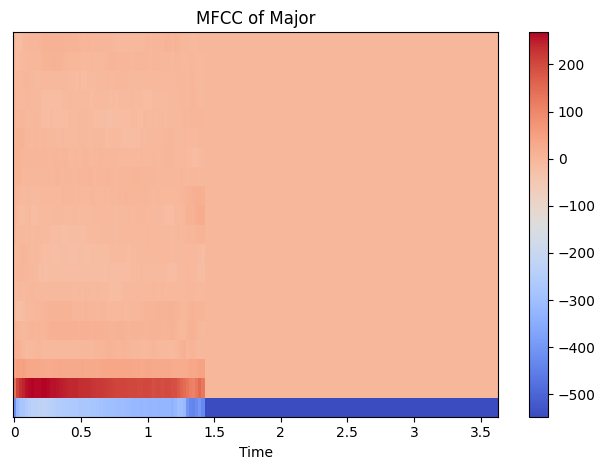

In [ ]:
librosa.display.specshow(librosa.feature.mfcc(y=X_raw[0], sr=16000), x_axis='time')
plt.title(f"MFCC of {y_raw[0]}")
plt.colorbar()
plt.tight_layout()
plt.show()

In [4]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_raw)

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mfcc)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded)

логистическая регрессия

In [43]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.55


In [21]:
len(X_train)

687

тензор

In [7]:
model_s = Sequential([
    Dense(64, activation='relu', input_shape=(13,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])


model_s.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [44]:
history = model_s.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

test_loss, test_acc = model_s.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_acc:.4f}")

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5894 - loss: 0.7268 - val_accuracy: 0.4203 - val_loss: 2.6031
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5894 - loss: 0.6666 - val_accuracy: 0.3986 - val_loss: 1.7337
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5883 - loss: 0.6856 - val_accuracy: 0.4275 - val_loss: 1.3569
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6480 - loss: 0.6449 - val_accuracy: 0.3986 - val_loss: 0.8937
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6716 - loss: 0.6301 - val_accuracy: 0.5145 - val_loss: 0.7844
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5956 - loss: 0.6524 - val_accuracy: 0.5435 - val_loss: 0.7947
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6448 - loss: 0.6329 - val_accuracy: 0.5217 - val_loss: 0.7963
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6379 - loss: 0.6357 - val_accuracy: 0.5507 - val_loss

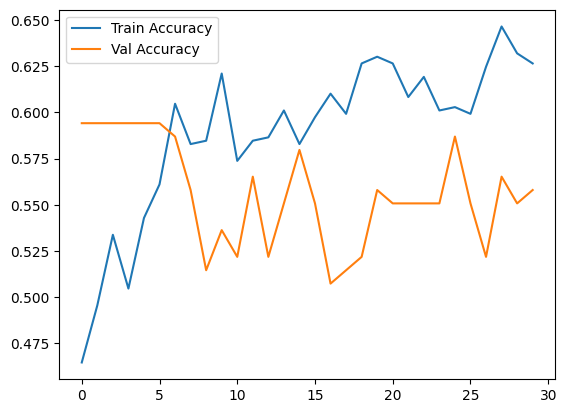

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()

дерево решений

In [45]:
model_t = DecisionTreeClassifier(
    max_depth=3,
    random_state=42
)
model_t.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model_t.predict(X_test)

In [46]:
# Точность (Accuracy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Отчёт по метрикам
print(classification_report(y_test, y_pred))

Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.61      0.88      0.72       101
           1       0.56      0.21      0.31        71

    accuracy                           0.60       172
   macro avg       0.58      0.55      0.51       172
weighted avg       0.59      0.60      0.55       172

